#### Here again import the necessary lib and the use the database to store the data , but to get the transcripts we use another lib which needs just the video_id (which we already have) and it return the transcripts in an unstructured format. This is for the new links.

In [1]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, VideoUnavailable
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time
import pickle
from collections import defaultdict
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from pymongo import MongoClient
import os
import pandas as pd

In [ ]:
with open('E:\\NLP_Recommender_System\\scraping\\random_processes\\scraped_links_2025.pkl', 'rb') as picklefile:
    links_video_ted = pickle.load(picklefile)

In [3]:
len(links_video_ted)

3212

In [ ]:
client = MongoClient()
client.list_database_names()
db = client['ted']

In [ ]:
db.create_collection("ted_transcript_new")
ted_transcripts = db.get_collection('ted_transcript_new')

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, VideoUnavailable
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time

# Fetch already processed video IDs from MongoDB
existing_videos = set(doc['url'] for doc in ted_transcripts.find({}, {'url': 1}))
remaining_videos = [vid for vid in links_video_ted if vid not in existing_videos]

print(f"🟢 {len(remaining_videos)} videos left to process.")

# Use tqdm with manual updates
progress_bar = tqdm(total=len(remaining_videos), desc="Fetching Transcripts", unit="video")

# Function to fetch transcript with timeout
def fetch_transcript(video_id):
    try:
        start_time = time.time()
        response = YouTubeTranscriptApi.get_transcript(video_id)
        elapsed_time = time.time() - start_time

        if elapsed_time > 10:  # Timeout condition
            raise TimeoutError("Transcript request took too long")

        ted_transcripts.insert_one({'url': video_id, 'transcript': response})
    
    except (TranscriptsDisabled, VideoUnavailable, TimeoutError) as e:
        ted_transcripts.insert_one({'url': video_id, 'transcript': f"Error: {str(e)}"})
    
    except Exception as e:
        ted_transcripts.insert_one({'url': video_id, 'transcript': f"Unknown Error: {str(e)}"})
    
    finally:
        progress_bar.update(1)  # Update tqdm progress

# Use ThreadPoolExecutor with tqdm progress tracking
with ThreadPoolExecutor(max_workers=5) as executor:
    executor.map(fetch_transcript, remaining_videos)

progress_bar.close()  # Close the progress bar after completion

print("✅ Completed transcript extraction!")

🟢 3212 videos left to process.


Fetching Transcripts: 100%|█████████▉| 3211/3212 [16:17<00:00,  1.77video/s]

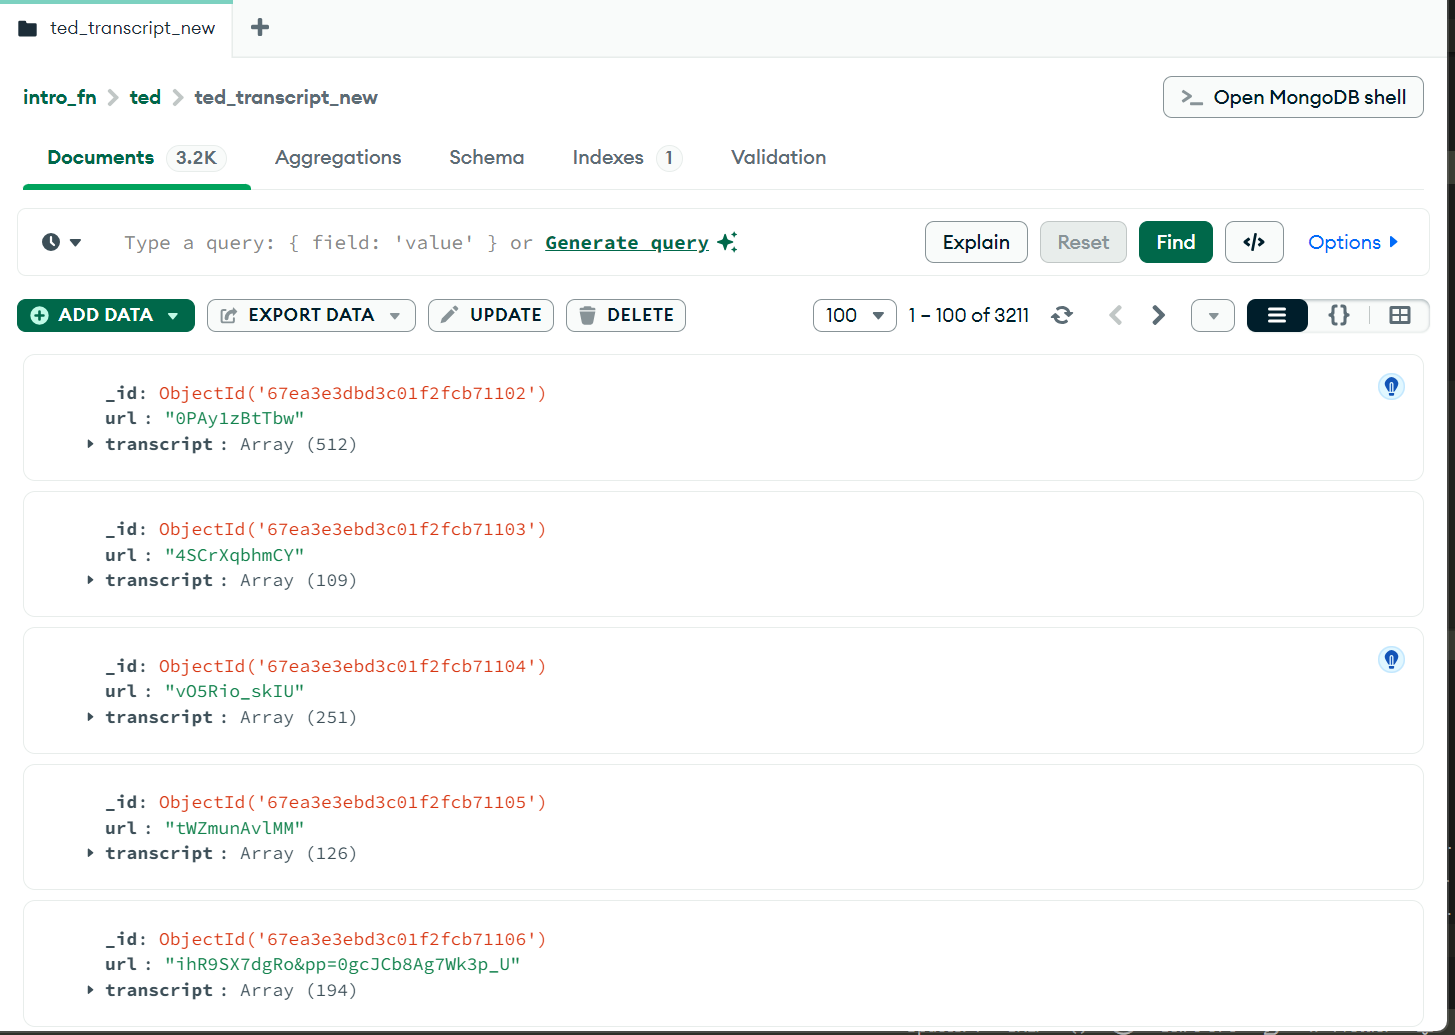